### 0.0. Dependencies and Data

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [183]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [184]:
print(retail_areas.dtypes)

date                                                       object
id                                                          int64
events                                                      int64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local_Footprint_Centre_ID                                  object
Residential Population (Weighted Catchment)                 int64
Retail Footprint Score                                    float64
Base Score                                                float64
Tourism Score                                             float64
Convenience_Score                                         float64
Retail_Footprint_Comparison_Retailer_Score                float64
Leisure_Footprint_Score                                   float64
Auto_Score                                                float64
Local Foot

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

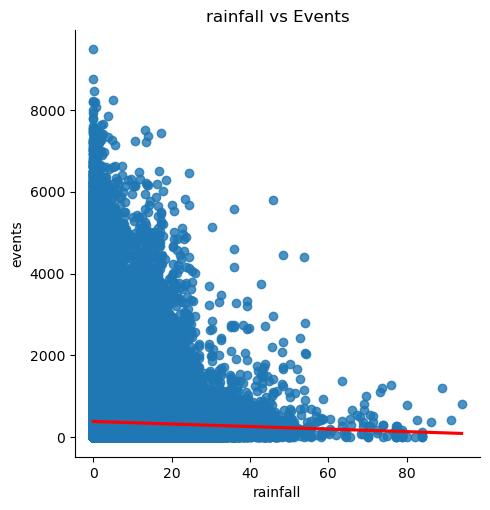

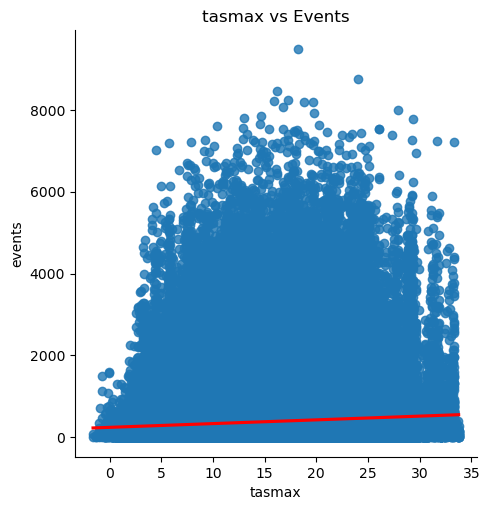

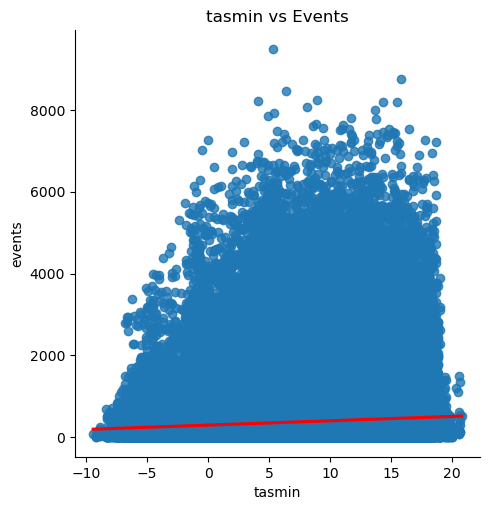

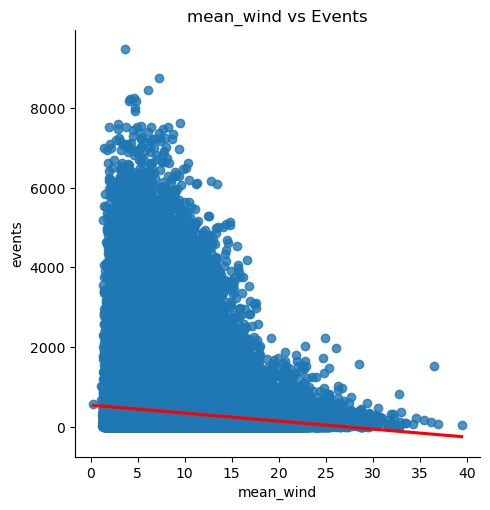

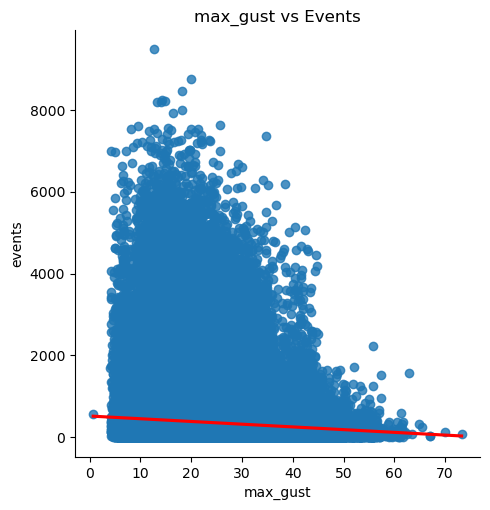

In [185]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.lmplot(x=var, y='events', data=retail_areas, line_kws={'color': 'red'})
    plt.title(f'{var} vs Events')
    plt.show() 

#### 1.1.2. Var encoding

In [186]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

In [187]:
# how many unique IDs per unique date?

### 1.2. General Model

#### 1.2.1. Without weather

Train/test:

In [188]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [189]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 6)
(418176,)
(104544, 6)
(104544,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time=  26.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  28.7s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  31.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  30.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  30.9s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  31.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  31.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  32.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  32.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  32.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  33.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  32.5s
[CV] END ..................m

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

KeyboardInterrupt: 

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6523281735700207
R² on the testing data:
0.6471284154113246


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6523251395827024
R² on the testing data:
0.6471421085978379


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
368.27645084403366
RMSE on the testing data:
371.46593281137706


                                             Importance
Feature                                                
Retail Footprint Score                         1.212554
Tourism Score                                  1.163175
Residential Population (Weighted Catchment)    1.032109
holiday                                        0.014729
weekend                                        0.009801


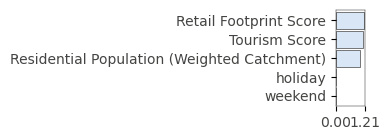

In [ ]:
from rfpimp import importances

imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.2. Add more vars

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns 
     if col.startswith('season_') or col.startswith('groupName_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'weekend', 'holiday', 'season_Spring', 'season_Summer', 'season_Winter', 'Sparsity_2 - Small Urban', 'Sparsity_3 - Urban', 'Sparsity_4 - Urban Dense', 'Sparsity_5 - Urban Dense (London)', 'Sparsity_6 - Retail Park']


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(418176, 13)
(418176,)
(104544, 13)
(104544,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=4; total time=  38.7s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  39.3s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  43.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  43.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  46.2s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  47.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  47.0s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  47.6s
[CV] END .................max_depth=10, min_samples_split=10; total time=  47.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  48.2s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  47.9s
[CV] END ..................max_depth=10, min_sa

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9372707145886405
R² on the testing data:
0.9304733131540865


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6742660771052531
R² on the testing data:
0.6674411372790765


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
321.7076861405185
RMSE on the testing data:
325.8697985985044


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.165521
Tourism Score                                  0.435412
Retail Footprint Score                         0.289664
Residential Population (Weighted Catchment)    0.213058
season_Winter                                  0.039649
season_Spring                                  0.018584
weekend                                        0.013008
season_Summer                                  0.006533
holiday                                        0.001784


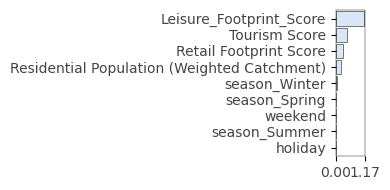

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.1. With weather

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 26)
(289303,)
(72326, 26)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END ..................m

Build random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9335726119917168
R² on the testing data:
0.5425975714438013


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.7947110956573961
R² on the testing data:
0.6683966526841578


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
284.8035722685265
RMSE on the testing data:
365.0433400669895


                                                    Importance
Feature                                                       
Retail Footprint Score                                1.548954
Sparsity_5 - Urban Dense (London)                     0.828570
Residential Population (Weighted Catchment)           0.609920
groupName_Sub-regional retail and leisure desti...    0.369437
Tourism Score                                         0.271170
groupName_Indie high streets                          0.079424
groupName_Mass and value high streets                 0.071502
groupName_Large regional retail and leisure des...    0.065459
Sparsity_6 - Retail Park                              0.045058
groupName_Local urban convenience centres             0.039722
groupName_Secondary retail parks and shopping c...    0.038813
Sparsity_4 - Urban Dense                              0.022123
season_Winter                                         0.014688
Sparsity_2 - Small Urban                              0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


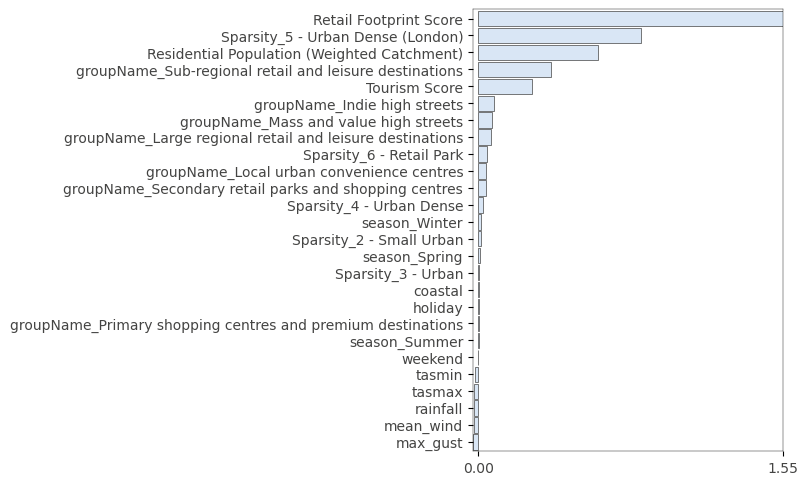

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 1.3. Model w/ retail type

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

#### 1.3.1. Without weather

Model:

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model.columns if col.startswith('season_')]

# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



Group: District urban service centres
R² (train): 0.701 | R² (test): 0.688
Feature Importances:
Sparsity_5 - Urban Dense (London)              0.487
Retail Footprint Score                         0.231
Tourism Score                                  0.168
Residential Population (Weighted Catchment)    0.060
season_Winter                                  0.019
season_Spring                                  0.014
weekend                                        0.009
season_Summer                                  0.005
holiday                                        0.004
coastal                                        0.001
Sparsity_3 - Urban                             0.001
Sparsity_2 - Small Urban                       0.001
Sparsity_4 - Urban Dense                       0.001
Sparsity_6 - Retail Park                       0.000
dtype: float64

Group: Indie high streets
R² (train): 0.760 | R² (test): 0.734
Feature Importances:
Retail Footprint Score                         0.260
Tourism 

Add calibration:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=-1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



KeyboardInterrupt: 

#### 1.3.2. With weather

In [ ]:
group_col = 'groupName'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + weather_vars + [col for col in df_model.columns if 
                    col.startswith('season_')]
 
# drop NaNs
df_model = df_model.dropna(subset=[target] + features)

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # Scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
R² (train): 0.922 | R² (test): 0.404
Feature Importances:
Tourism Score                                  0.407
Retail Footprint Score                         0.232
mean_wind                                      0.088
max_gust                                       0.083
Residential Population (Weighted Catchment)    0.045
tasmax                                         0.037
tasmin                                         0.036
rainfall                                       0.033
season_Winter                                  0.013
season_Spring                                  0.012
weekend                                        0.007
season_Summer                                  0.003
coastal                                        0.002
holiday                                        0.001
dtype: float64

Group: Indie high streets
R² (train): 0.947 | R² (test): 0.622
Feature Importances:
Retail Footprint Score                         0.276
Tourism 

Add calibration:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


KeyboardInterrupt: 

Partial dependence plots:

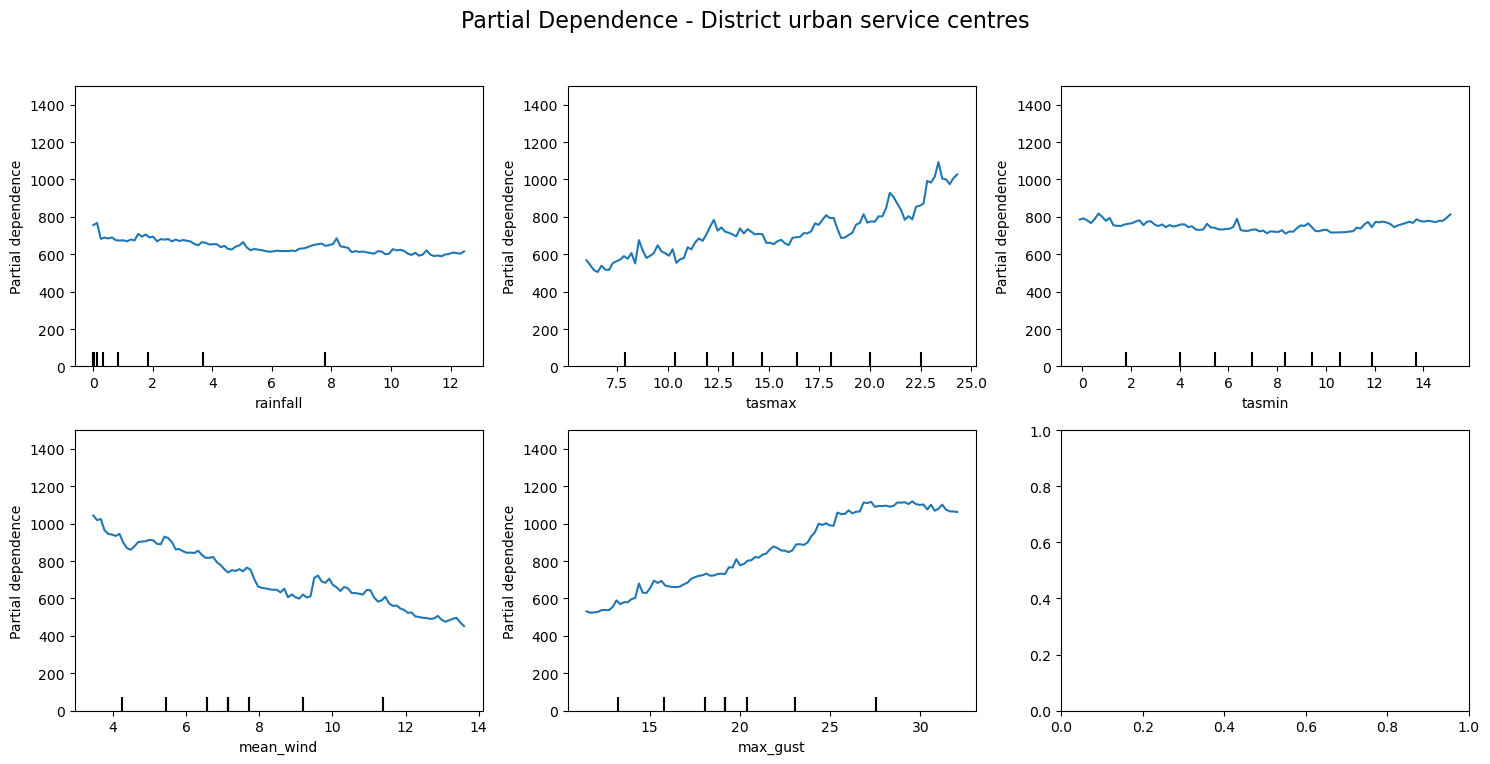

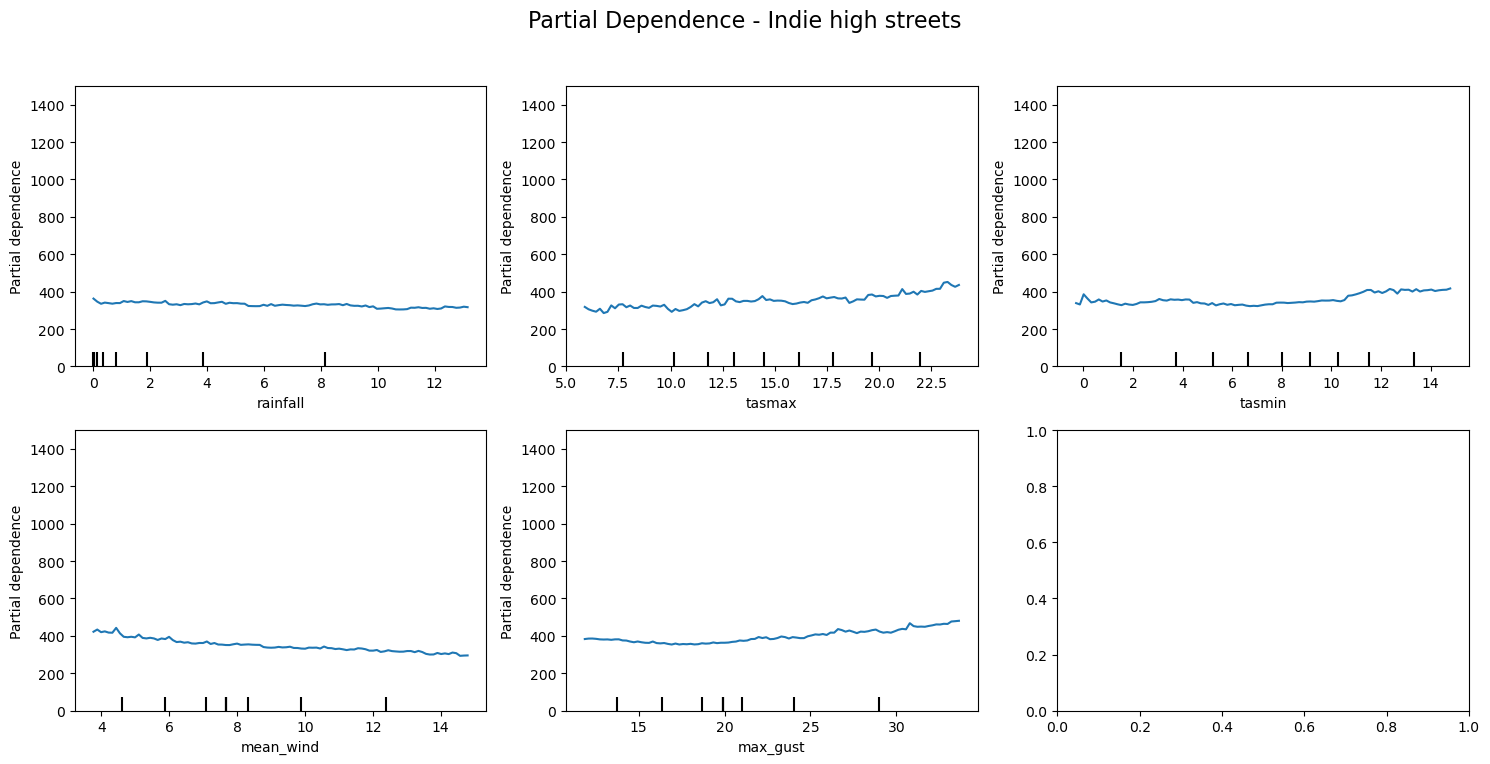

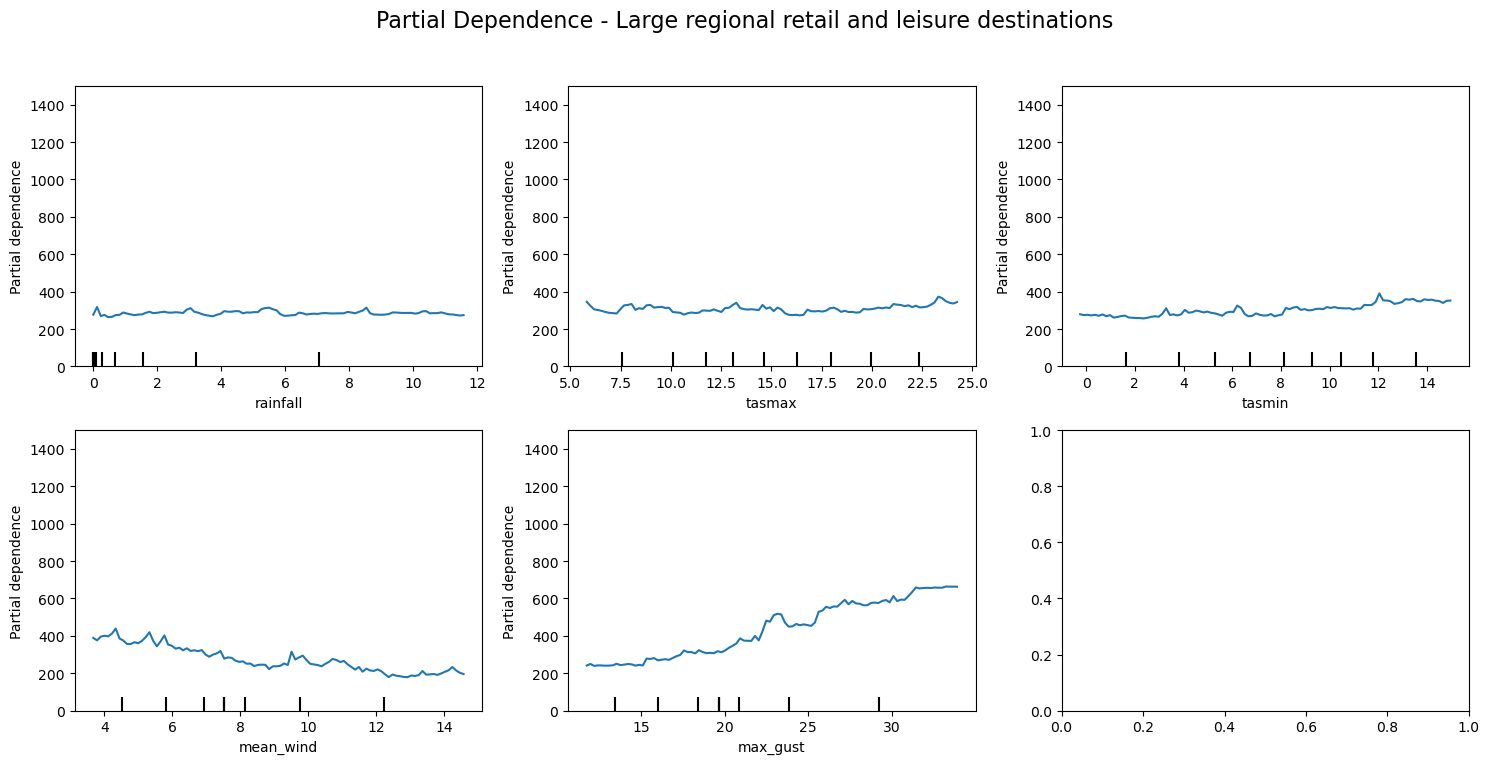

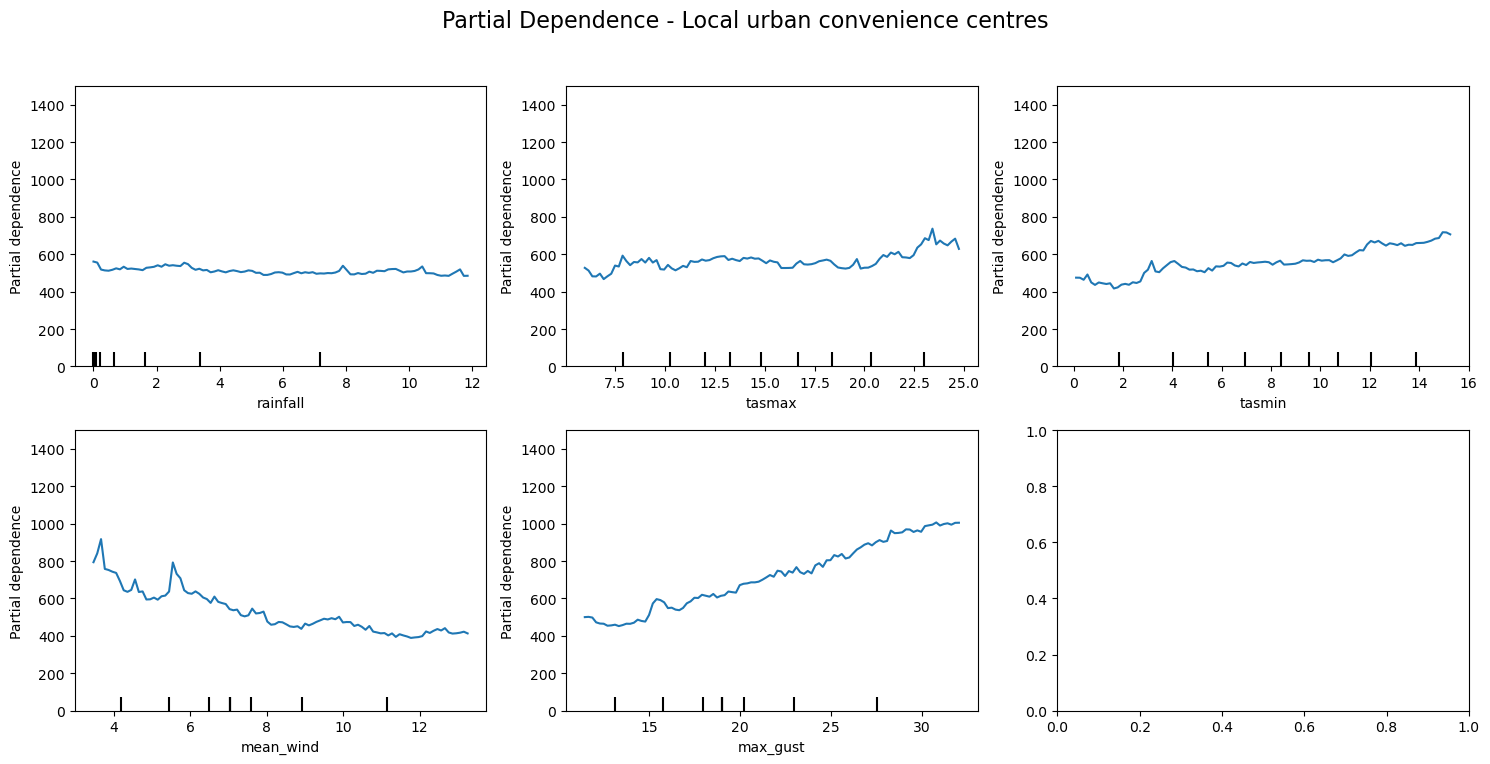

KeyboardInterrupt: 

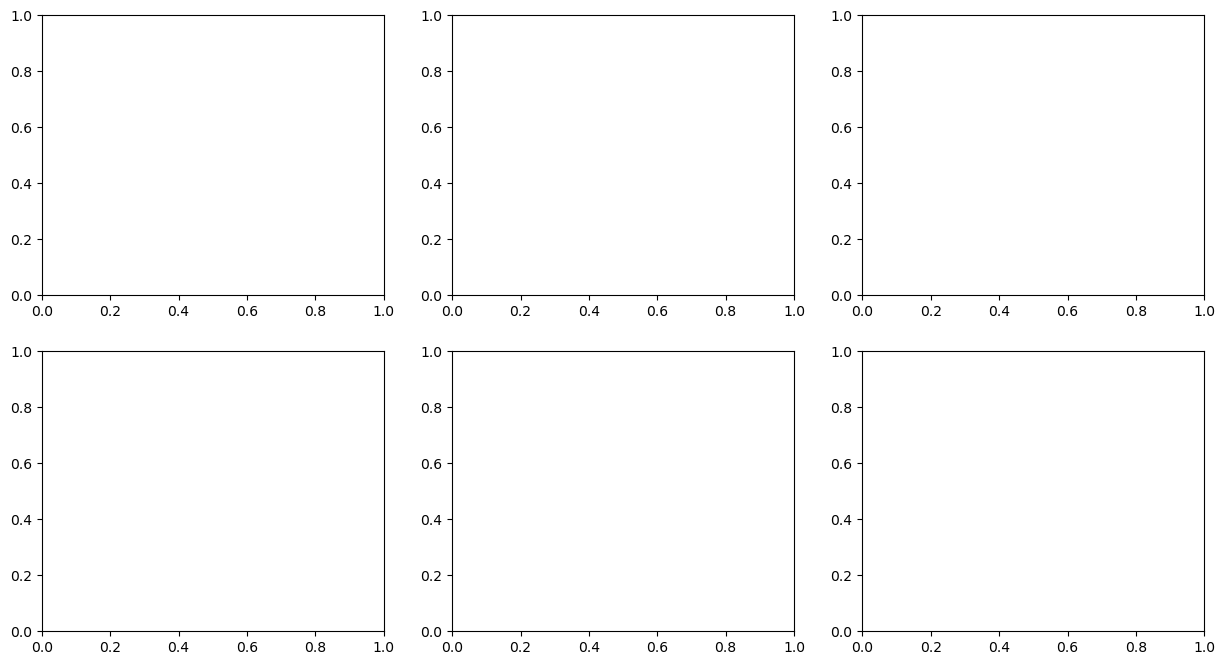

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # Skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # Handle missing values (robustness)
    X = X.fillna(X.median())

    # Fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # Prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # Plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # Optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 1.4. Retail model per sparsity

- London
- Other urban
- Rural 
- Coastal

In [ ]:
#...

#### later

Leisure footprint?
rail/tube--- specifically for london?